## Latihan ARIMA-Transformer

In [1]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, anderson
from scipy.special import boxcox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
data_df = pd.read_excel('QBO Data.xlsx')
columns_name = ['25 hPa']
Data = pd.DataFrame(data_df, columns=columns_name)
time_series_numpy = Data.values.astype(str)  # Replace 'your_column_name' with the actual column name

# Seasonal features (assuming you have a time index)
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d%m%Y')
data_df.set_index('Date', inplace=True)

In [3]:
Data.head()

,25 hPa
0,-289
1,-280
2,-309
3,-303
4,-289


In [4]:
Data.describe()

,25 hPa
count,419.000000
mean,-77.694511
std,194.269672
min,-364.000000
25%,-291.500000
50%,-36.000000
75%,112.000000
max,206.000000


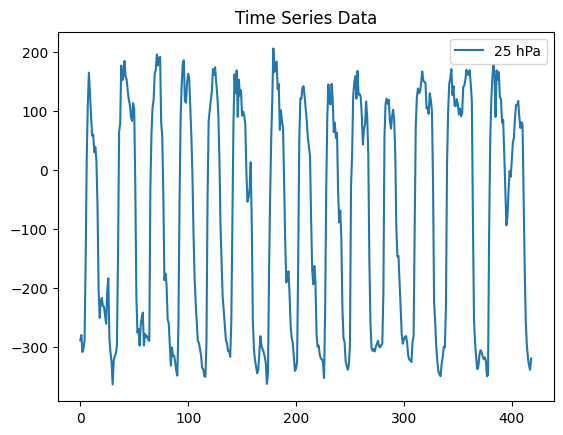

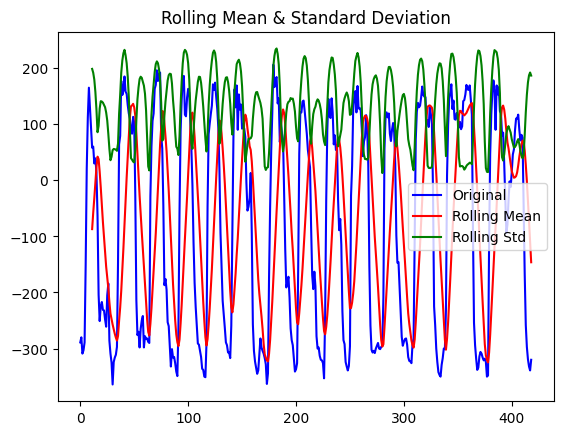

ADF Statistic: -8.94207571372283
p-value: 9.195652310623386e-15
Critical Values:
	 1% : -3.4465195891135845
	 5% : -2.8686676281678634
	 10% : -2.5705668101226085


In [5]:
def check_stationarity(data):
    # Hapus nilai inf dan NaN
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Calculate rolling statistics
    rolling_mean = data.rolling(window=12).mean()
    rolling_std = data.rolling(window=12).std()

    # Plot rolling statistics
    plt.plot(data, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Augmented Dickey-Fuller test
    adf_result = adfuller(data)
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print('\t', key, ':', value)

# Plot the time series data
Data.plot()
plt.title('Time Series Data')
plt.show()

# Check stationarity and trends
check_stationarity(Data)

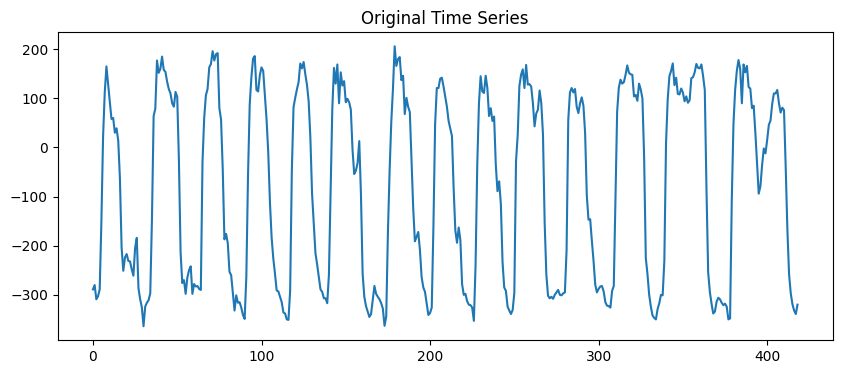

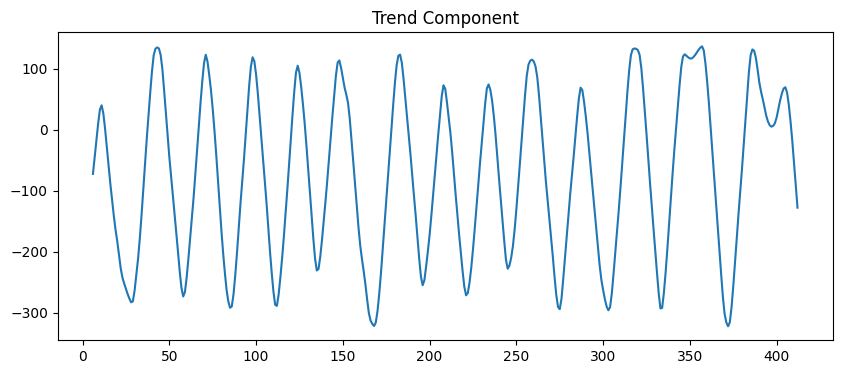

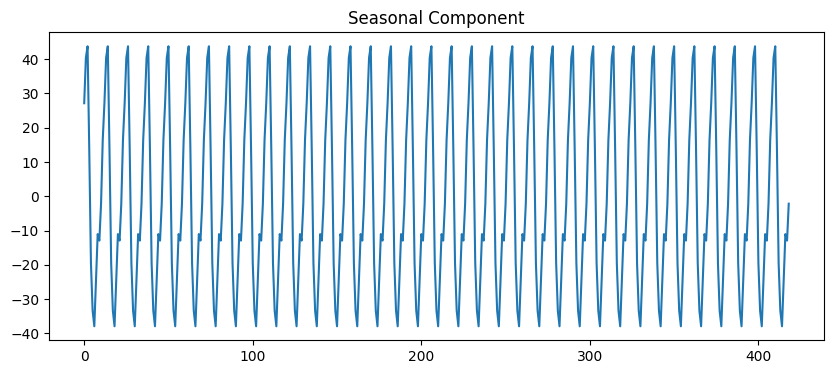

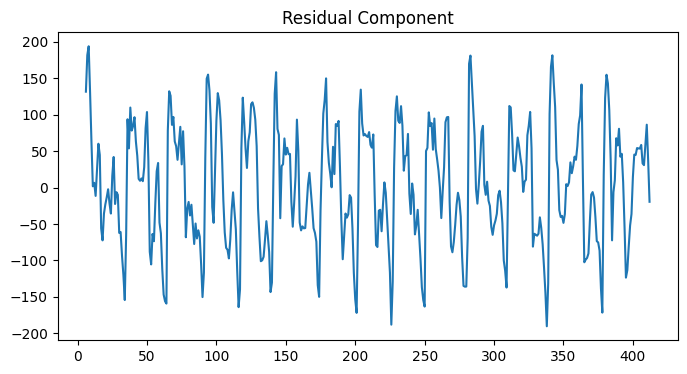

In [6]:
# Perform seasonal decomposition
result = seasonal_decompose(Data['25 hPa'], model='additive', period=12)  # Adjust the period according to your data

# Plot the original time series
plt.figure(figsize=(10, 4))
plt.plot(Data['25 hPa'])
plt.title('Original Time Series')
plt.show()

# Plot the trend component
plt.figure(figsize=(10, 4))
plt.plot(result.trend)
plt.title('Trend Component')
plt.show()

# Plot the seasonal component
plt.figure(figsize=(10, 4))
plt.plot(result.seasonal)
plt.title('Seasonal Component')
plt.show()

# Plot the residual component
plt.figure(figsize=(8, 4))
plt.plot(result.resid)
plt.title('Residual Component')
plt.show()

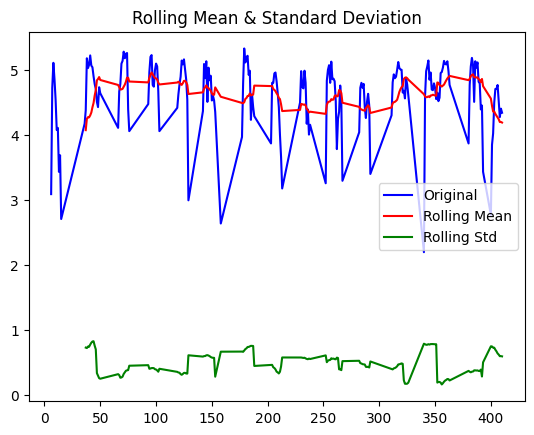

ADF Statistic: -8.318681971197375
p-value: 3.6219272868604197e-13
Critical Values:
	 1% : -3.464337030867007
	 5% : -2.876478799035722
	 10% : -2.574733103221565


In [7]:
# Apply logarithmic transformation
log_transformed_data = np.log1p(Data['25 hPa'])

# Check stationarity for the log-transformed data
check_stationarity(log_transformed_data)

In [8]:
# Geser data agar semua nilai positif (hindari log dari nilai <= -1)
shifted_data = Data['25 hPa'] - Data['25 hPa'].min() + 1

# Lakukan log1p transformasi
log_transformed_data = np.log1p(shifted_data)

# Drop NaN hasil transformasi (jika ada)
log_transformed_data_clean = log_transformed_data.dropna()

# Jumlah NaN setelah pembersihan
log_transformed_data_clean.isna().sum()


0

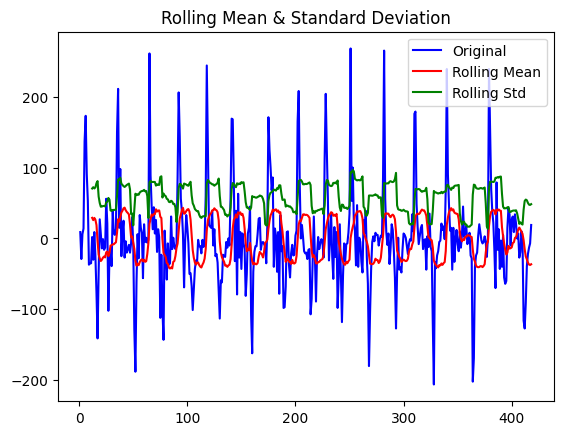

ADF Statistic: -9.116291567040088
p-value: 3.2955830655125668e-15
Critical Values:
	 1% : -3.4468044036406247
	 5% : -2.868792838125
	 10% : -2.57063355625


In [9]:
differenced_data = Data['25 hPa'].diff().dropna()

check_stationarity(differenced_data)

In [10]:
# Perform Shapiro-Wilk test for normality on the original data
stat_orig, p_orig = shapiro(Data['25 hPa'])
print('Shapiro-Wilk Test (Original Data)')
print('Test Statistic:', stat_orig)
print('p-value:', p_orig)


# Perform Shapiro-Wilk test for normality on the original data
stat_orig, p_orig = shapiro(differenced_data)
print('Shapiro-Wilk Test (Original Data)')
print('Test Statistic:', stat_orig)
print('p-value:', p_orig)

Shapiro-Wilk Test (Original Data)
Test Statistic: 0.8510827275188056
p-value: 1.7109566257496403e-19
Shapiro-Wilk Test (Original Data)
Test Statistic: 0.87736386815381
p-value: 1.0771803245326146e-17


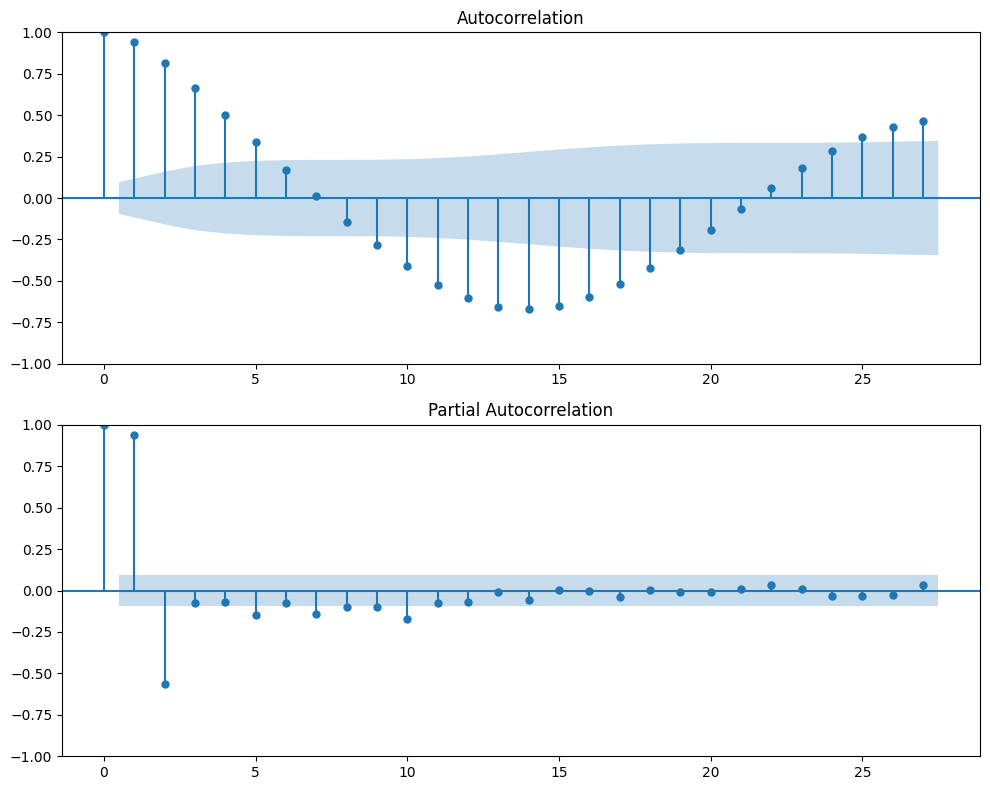

In [11]:
# Visualize the ACF and PACF plots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(Data['25 hPa'], ax=axes[0])
plot_pacf(Data['25 hPa'], ax=axes[1])
plt.tight_layout()
plt.show()

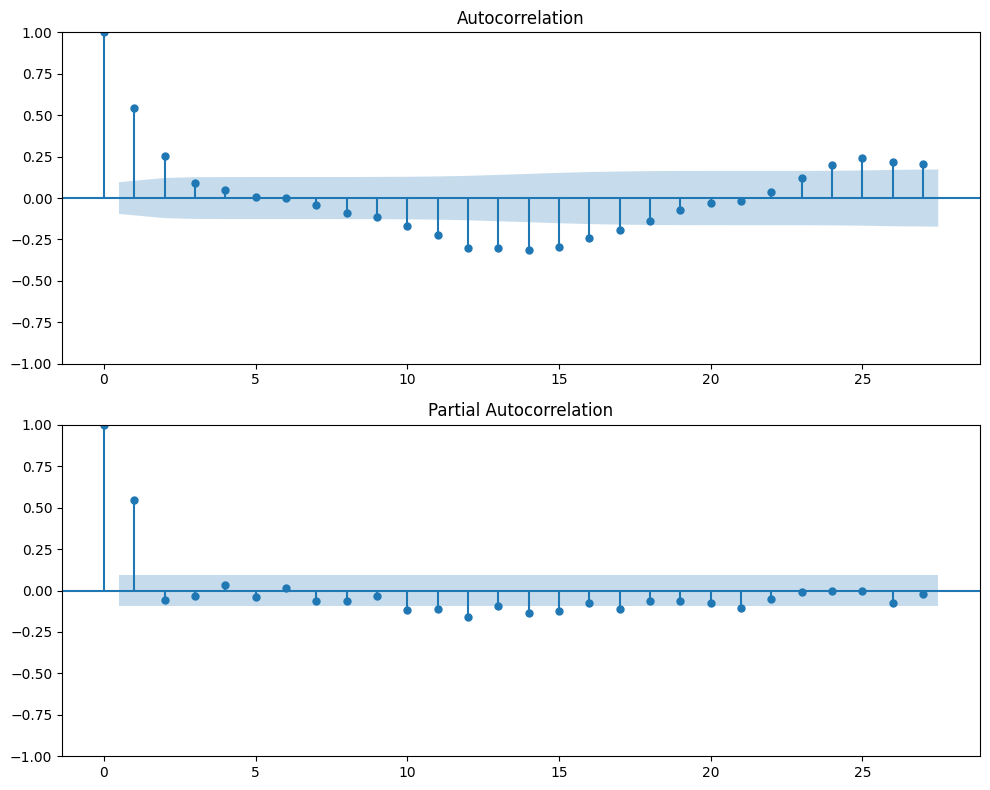

In [12]:
# Visualize the ACF and PACF plots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(differenced_data, ax=axes[0])
plot_pacf(differenced_data, ax=axes[1])
plt.tight_layout()
plt.show()

In [13]:
# Define the range of p, d, q values
p_values = [1, 2, 3, 4, 5, 6]
d_values = [0, 1, 2]
q_values = [1, 2, 3, 4, 5, 6]

# Create a list of all possible combinations of p, d, q
param_combinations = list(itertools.product(p_values, d_values, q_values))

best_model = None
best_mse = float('inf')  # Initialize with a large value

# Loop through all combinations
for params in param_combinations:
    p, d, q = params

    # Fit the ARIMA model
    model_ARIMA = ARIMA(Data['25 hPa'], order=(p, d, q))
    model_ARIMA_fit = model_ARIMA.fit()

    # Make predictions
    predictions = model_ARIMA_fit.predict(start=1, end=len(Data['25 hPa']))

    # Evaluate the model using Mean Squared Error (MSE)
    mse = mean_squared_error(Data['25 hPa'], predictions)

    # Update the best model if the current one is better
    if mse < best_mse:
        best_mse = mse
        best_model = model_ARIMA_fit
        best_params = params

# Print the best model and its parameters
print("Best Model Parameters (p, d, q):", best_params)
print("Best Model MSE:", best_mse)
print(best_model.summary())

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\AppData\Local\Packages\PythonSoftw

Best Model Parameters (p, d, q): (1, 0, 1)
Best Model MSE: 741.001180844646
                               SARIMAX Results                                
Dep. Variable:                 25 hPa   No. Observations:                  419
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2278.943
Date:                Fri, 23 May 2025   AIC                           4565.885
Time:                        13:11:57   BIC                           4582.037
Sample:                             0   HQIC                          4572.270
                                - 419                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -88.6084     49.730     -1.782      0.075    -186.077       8.860
ar.L1          0.9108      0.031     29.777      0.000 

In [14]:
# Determine the percentage of data to be used for training
train_percentage = 0.8

# Split the time series into training and validation sets
train_size = int(len(Data['25 hPa']) * train_percentage)
train_data = Data['25 hPa'][:train_size]
val_data = Data['25 hPa'][train_size:]

In [15]:
# Define the ARIMA order (p, d, q)
p = 4  # replace with your identified value
d = 0   # replace with your identified value
q = 5  # replace with your identified value

# Fit ARIMA model on training data

model_ARIMA = ARIMA(train_data, order=(p, d, q))
model_ARIMA_fit = model_ARIMA.fit()

# Predictions for training data
predictions_train = model_ARIMA_fit.predict(start=1, end=len(train_data))

# Predictions for entire data
predictions_entire = model_ARIMA_fit.predict(start=1, end=len(Data['25 hPa']))

# Make predictions on validation data
predictions_val = model_ARIMA_fit.predict(start=len(train_data), end=len(Data['25 hPa'])-1, typ='levels')

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
# Display the summary
print(model_ARIMA_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 25 hPa   No. Observations:                  335
Model:                 ARIMA(4, 0, 5)   Log Likelihood               -1776.942
Date:                Fri, 23 May 2025   AIC                           3575.883
Time:                        13:12:01   BIC                           3617.838
Sample:                             0   HQIC                          3592.609
                                - 335                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -86.7051      0.851   -101.839      0.000     -88.374     -85.036
ar.L1          1.2553      1.050      1.195      0.232      -0.803       3.314
ar.L2          0.5918      2.104      0.281      0.7

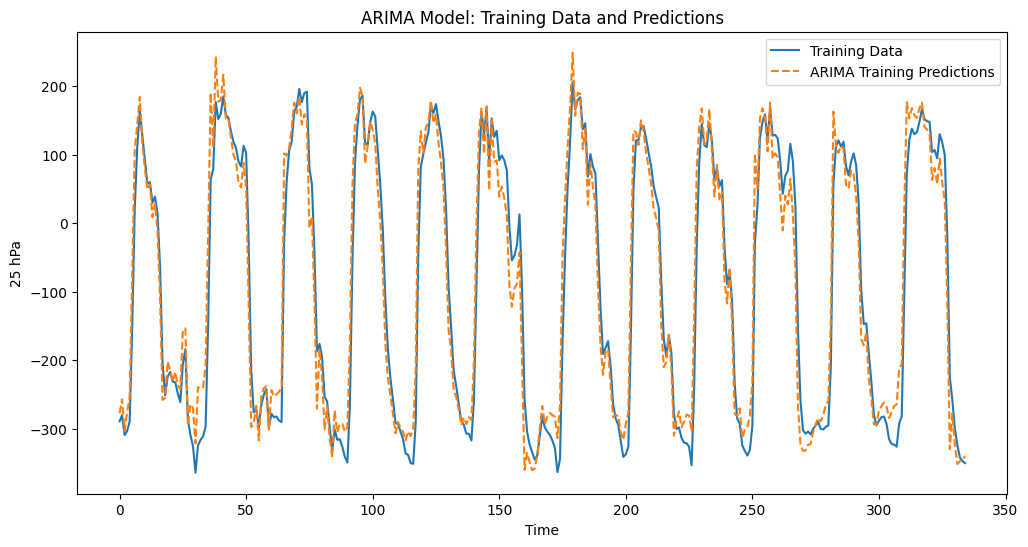

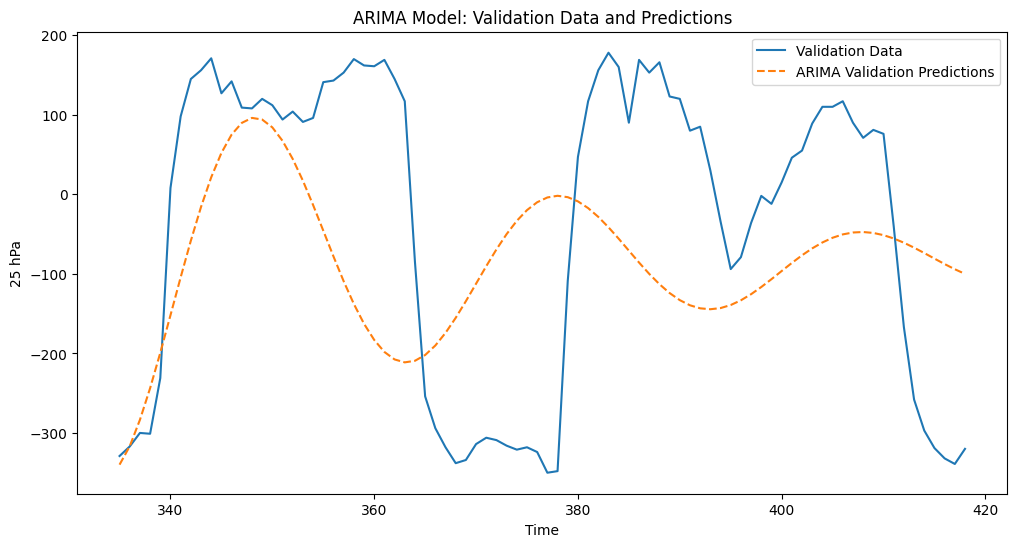

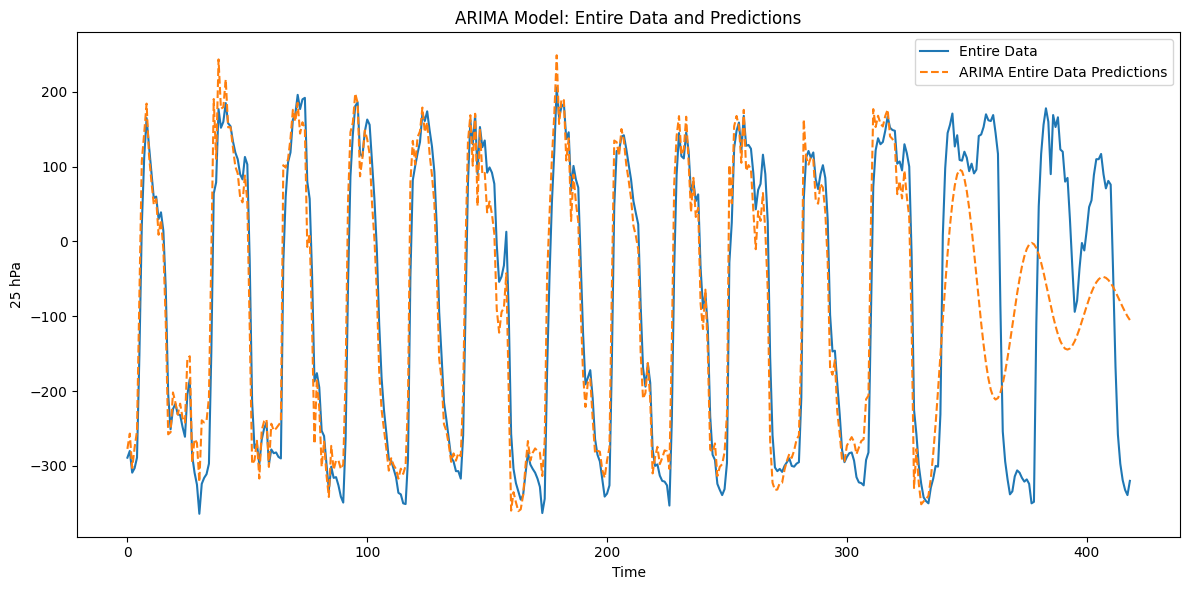

In [17]:
# Plotting train data and train predictions
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(train_data.index, predictions_train, label='ARIMA Training Predictions', linestyle='--')
plt.title('ARIMA Model: Training Data and Predictions')
plt.xlabel('Time')
plt.ylabel('25 hPa')
plt.legend()

# Plotting test data and test predictions
plt.figure(figsize=(12, 6))
plt.plot(val_data.index, val_data, label='Validation Data')
plt.plot(val_data.index, predictions_val, label='ARIMA Validation Predictions', linestyle='--')
plt.title('ARIMA Model: Validation Data and Predictions')
plt.xlabel('Time')
plt.ylabel('25 hPa')
plt.legend()

# Plotting entire data and entire predictions
plt.figure(figsize=(12, 6))
plt.plot(Data['25 hPa'], label='Entire Data')
plt.plot(Data['25 hPa'].index, predictions_entire, label='ARIMA Entire Data Predictions', linestyle='--')
plt.title('ARIMA Model: Entire Data and Predictions')
plt.xlabel('Time')
plt.ylabel('25 hPa')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
def calculate_metrics_and_print(original_data, predictions, model_order):
    # Mean Squared Error (MSE)
    mse = mean_squared_error(original_data, predictions)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # R-squared (R2)
    r2 = r2_score(original_data, predictions)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(original_data, predictions)

    # Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) using the relative formula
    n = len(original_data)
    k = len(model_order)  # Number of parameters in the model
    aic = n * np.log(mse) + 2 * k
    bic = n * np.log(mse) + k * np.log(n)

    # Log Likelihood
    log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(mse)

    # Mean Absolute Percentage Error (MAPE)
    ape = np.abs((original_data - predictions) / original_data)
    mape = np.mean(ape) * 100

    # Print the metrics
    print("Metrics for Original Data Model:")
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("R-squared: ", r2)
    print("MAE: ", mae)
    print("AIC: ", aic)
    print("BIC: ", bic)
    print("Log Likelihood: ", log_likelihood)
    print("MAPE: ", mape)

In [19]:
# Example usage
model_order = (p, d, q)  # Replace with the actual values of p, d, q
calculate_metrics_and_print(Data['25 hPa'], predictions_entire, model_order)

Metrics for Original Data Model:
MSE:  9495.322172872171
RMSE:  97.44394374650572
R-squared:  0.7478044427228299
MAE:  62.616315711272435
AIC:  3843.434357900986
BIC:  3855.5479706607525
Log Likelihood:  -2303.7524243632506
MAPE:  78.66341456508175


In [20]:
# Example usage
model_order = (p, d, q)  # Replace with the actual values of p, d, q
calculate_metrics_and_print(train_data, predictions_train, model_order)

Metrics for Original Data Model:
MSE:  2064.583824232511
RMSE:  45.43769166927949
R-squared:  0.9444070731195635
MAE:  35.16130632625353
AIC:  2562.9491223058726
BIC:  2574.391513901348
Log Likelihood:  -1586.3189697765017
MAPE:  41.0541271672315


In [21]:
# Example usage
model_order = (p, d, q)  # Replace with the actual values of p, d, q
calculate_metrics_and_print(val_data, predictions_val, model_order)

Metrics for Original Data Model:
MSE:  37205.94576657428
RMSE:  192.88842828582094
R-squared:  0.003213505160069907
MAE:  167.1424618492388
AIC:  890.0348042336318
BIC:  897.3272546301617
Log Likelihood:  -519.2082389060084
MAPE:  228.20510493272445


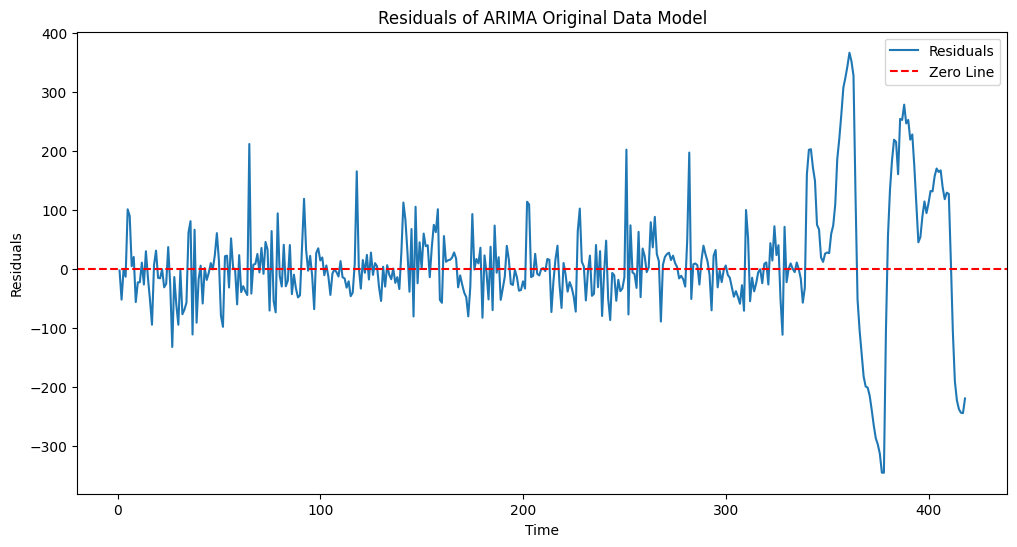

In [22]:
# Calculate residuals
residuals = Data['25 hPa'] - predictions_entire

# Drop NaN values from residuals
residuals = residuals.dropna()

# residuals = val_data - predictions_val

# residuals = residuals.dropna()

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

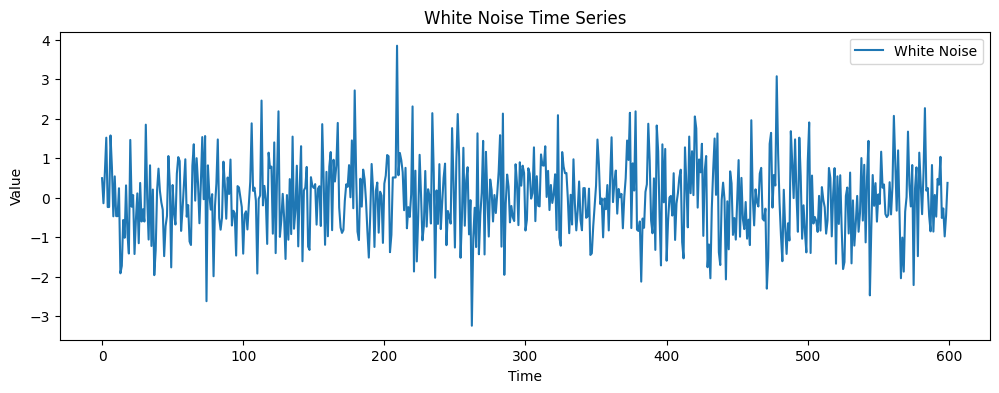

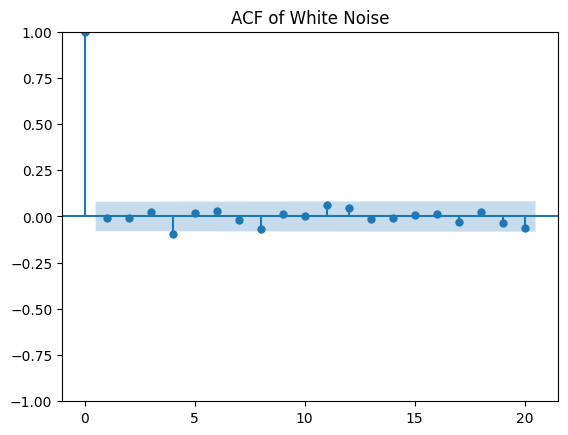

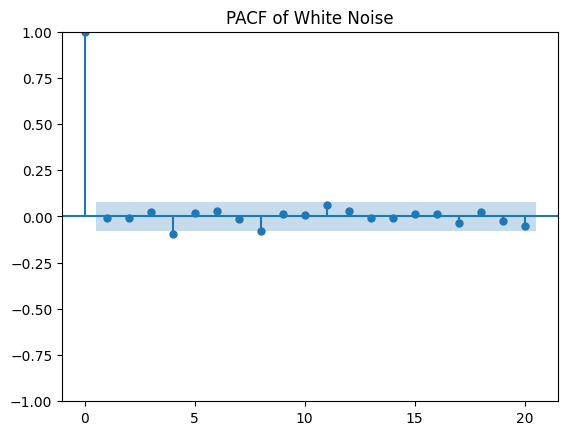

In [23]:
# Set a seed for reproducibility
np.random.seed(42)

# Generate white noise with 100 data points
white_noise = np.random.normal(size=600)

# Plot the white noise time series
plt.figure(figsize=(12, 4))
plt.plot(white_noise, label='White Noise')
plt.title('White Noise Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot ACF and PACF for white noise
acf_white_noise = plot_acf(white_noise, lags=20, title='ACF of White Noise')
pacf_white_noise = plot_pacf(white_noise, lags=20, title='PACF of White Noise')

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9005717218525924
P-value: 7.028368927161059e-16
The residuals may not be normally distributed.
Anderson-Darling Test (Normality):
Test Statistic: 15.061092973685618
The data is likely not normal at the 15.0% significance level.
The data is likely not normal at the 10.0% significance level.
The data is likely not normal at the 5.0% significance level.
The data is likely not normal at the 2.5% significance level.
The data is likely not normal at the 1.0% significance level.


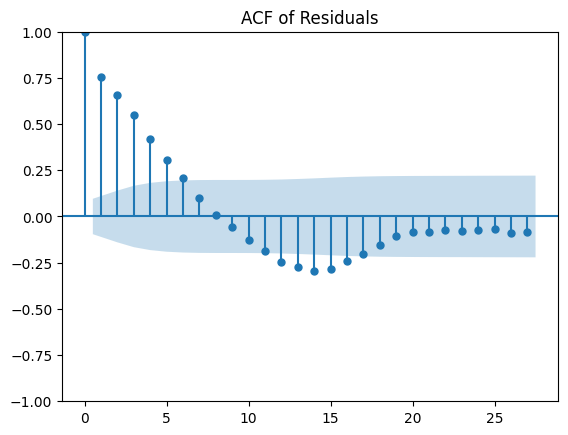

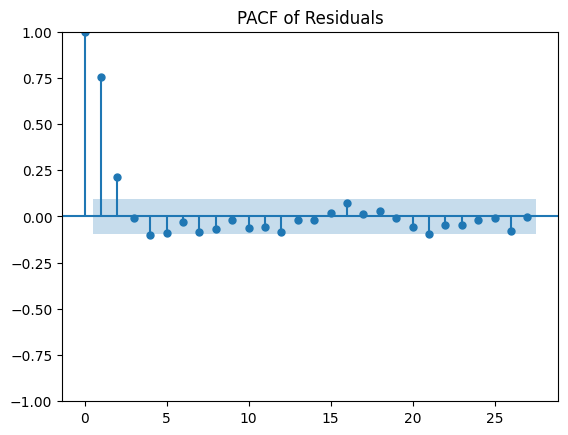

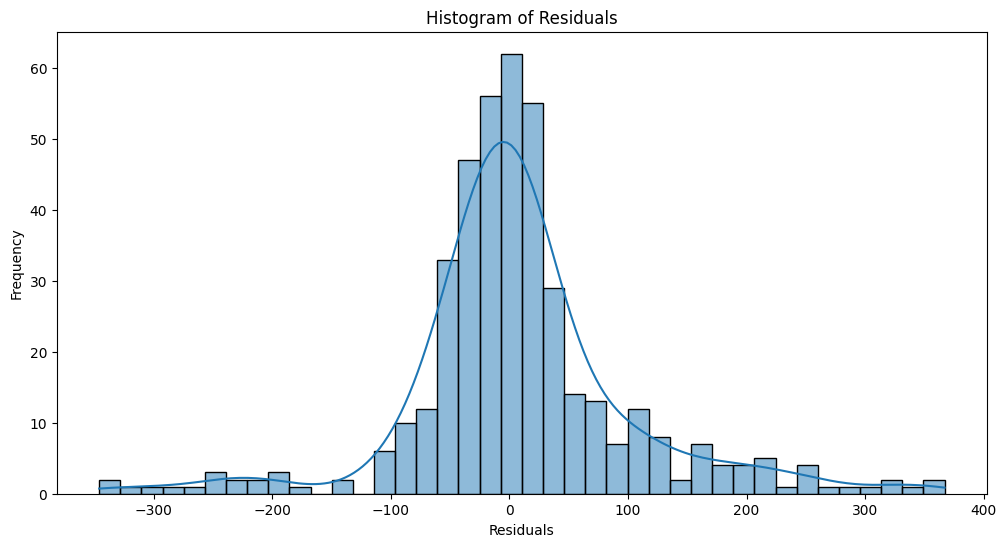

In [24]:
# Check for normality using the Shapiro-Wilk test
stat, p_value = shapiro(residuals)
print("Shapiro-Wilk Test (Normality):")
print("Test Statistic:", stat)
print("P-value:", p_value)
if p_value > 0.05:
    print("The residuals appear to be normally distributed.")
else:
    print("The residuals may not be normally distributed.")

# Perform the Anderson-Darling test for normality
result = anderson(residuals)

# Extract the test statistic and critical values
test_statistic = result.statistic
critical_values = result.critical_values

# Compare the test statistic with critical values
print("Anderson-Darling Test (Normality):")
print("Test Statistic:", test_statistic)

# Interpret the results based on critical values
for i, cv in enumerate(critical_values):
    if test_statistic < cv:
        print(f"The data may be normal at the {result.significance_level[i]}% significance level.")
    else:
        print(f"The data is likely not normal at the {result.significance_level[i]}% significance level.")


# Plot ACF and PACF on residuals
acf_res = plot_acf(residuals,  title='ACF of Residuals')
pacf_res = plot_pacf(residuals,  title='PACF of Residuals')

# Plot histogram of residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()